In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'ffss'))
sys.path.append(str(Path.cwd().parent / 'ffss' / 'data'))

In [2]:
from ffss.data.dataset import LabelAnythingDataset, VariableBatchSampler

from ffss.data import get_preprocessing
from ffss.substitution import Substitutor
from ffss.models import MODEL_REGISTRY
from ffss.utils.utils import ResultDict
from ffss.demo.visualize import feature_map_pca_heatmap
from ffss.data.utils import BatchKeys
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import lovely_tensors as lt
from einops import rearrange
from sklearn.decomposition import PCA
import torch.nn as nn
lt.monkey_patch()

In [5]:
%matplotlib inline

In [41]:
def get_raw_attn(result):
    fg_raws = result.get(ResultDict.FG_RAW_ATTN_OUTS, None)
    bg_raws = result.get(ResultDict.BG_RAW_ATTN_OUTS, None)
    if fg_raws is None:
        return None
    fg_raw_list = []
    bg_raw_list = []
    for raw_attn1, raw_attn2, raw_attn3 in fg_raws:
        raw_attn1 = F.interpolate(raw_attn1, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw_attn2 = F.interpolate(raw_attn2, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw_attn3 = F.interpolate(raw_attn3, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw = torch.cat([raw_attn1, raw_attn2, raw_attn3], dim=1).mean(dim=1).unsqueeze(1)
        # raw = F.sigmoid(raw)
        fg_raw_list.append(raw)
    for raw_attn1, raw_attn2, raw_attn3 in bg_raws:
        raw_attn1 = F.interpolate(raw_attn1, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw_attn2 = F.interpolate(raw_attn2, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw_attn3 = F.interpolate(raw_attn3, raw_attn3.size()[-2:], mode='bilinear', align_corners=True)
        raw = torch.cat([raw_attn1, raw_attn2, raw_attn3], dim=1).mean(dim=1).unsqueeze(1)
        # raw = F.sigmoid(raw)
        bg_raw_list.append(raw)
    return fg_raw_list, bg_raw_list

# Functions for visualization

def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 480)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]


colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

In [42]:
RAW_DATA_DIR = Path.cwd().parent / "data"

In [43]:
dataset_params = {
    "datasets": {
        "val_pascal5i_N1K1": {
            "name": "pascal",
            "data_dir": RAW_DATA_DIR / "pascal",
            "split": "val",
            "val_fold_idx": 1,
            "n_folds": 4,
            "n_shots": 1,
            "n_ways": 1,
            "do_subsample": False
        }
    },
    "common": {
        "remove_small_annotations": True,
        "image_size": 384,
        "custom_preprocess": False
    }
}

In [44]:
preprocess = get_preprocessing(dataset_params)

In [45]:
val_datsets = {}
common_params = dataset_params["common"]
for name, single_dataset_params in dataset_params["datasets"].items():
    splits = name.split("_")
    if len(splits) > 2:
        dataset_name = "_".join(splits[:2])
    dataset = LabelAnythingDataset(
        datasets_params={dataset_name: single_dataset_params},
        common_params={**common_params, "preprocess": preprocess},
    )
    val_datsets[name] = dataset

Loading image filenames from val...
[2025-01-09 15:25:23] WARNING - pascal.py - load_embeddings is not specified. Assuming load_embeddings=False.


Loading annotations...: 100%|██████████| 1449/1449 [00:01<00:00, 863.43it/s]


In [46]:
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 2, 1]],
        num_processes=1,
        shuffle=False,
)

In [47]:
val_datsets.keys()

dict_keys(['val_pascal5i_N1K1'])

In [48]:
chosen_dataset = "val_pascal5i_N1K1"

dataset = val_datsets["val_pascal5i_N1K1"]

In [49]:
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)

In [76]:
model = MODEL_REGISTRY['dcama'](
    backbone_checkpoint="../checkpoints/swin_base_patch4_window12_384.pth",
    model_checkpoint="../checkpoints/swin_fold0_pascal_modcross.pt",
    concat_support=False
)
model = model.eval()

In [77]:
idx = 0
for batch_idx, ((batch, gt), _) in enumerate(dataloader):
    print(batch_idx)
    if batch_idx == idx:
        break 

0


In [78]:
sample = {
    k: v[0] for k, v in batch.items()
}

In [79]:
images = [
    draw_all(
        get_image(sample["images"][i]),
        sample["prompt_masks"][i],
        sample["prompt_bboxes"][i],
        sample["prompt_points"][i],
        colors
    )
    for i in range(sample["images"].shape[0])
]

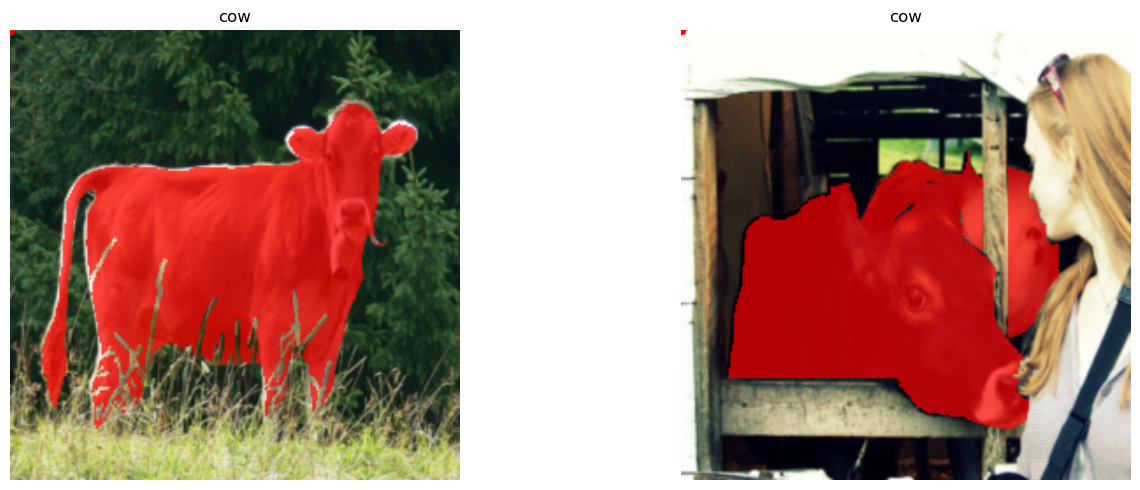

In [80]:
# show examples in a single figure
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, (example, ax) in enumerate(zip(images, axes)):
    cats = [dataset.categories["val_pascal5i"][cat]["name"] for cat in sample["classes"][i]]
    ax.set_title(", ".join(cats))
    ax.imshow(example)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [81]:
sub = Substitutor(substitute=False)
sub.reset((batch, gt))
batch_dict, gt = next(sub)

In [82]:
aggregation = "sum"
kwargs = {
    "temperature": 1.0
}

model.set_attn_fn(aggregation=aggregation, **kwargs)

In [103]:
x = batch_dict
with torch.no_grad():
    masks = model._preprocess_masks(
        x[BatchKeys.PROMPT_MASKS], x[BatchKeys.DIMS]
    )
    assert (
        masks.shape[0] == 1
    ), "Only tested with batch size = 1"
    results = []
    # get logits for each class
    c = 0
    class_examples = x[BatchKeys.FLAG_EXAMPLES][:, :, c + 1]
    n_shots = class_examples.sum().item()
    class_input_dict = {
        BatchKeys.IMAGES: x[BatchKeys.IMAGES],
        BatchKeys.PROMPT_MASKS: masks[:, :, c, ::][
            class_examples
        ].unsqueeze(0),
    }

In [104]:
with torch.no_grad():
    query_img = class_input_dict[BatchKeys.IMAGES][:, 0]
    support_imgs = class_input_dict[BatchKeys.IMAGES][:, 1:]
    support_masks = class_input_dict[BatchKeys.PROMPT_MASKS]
    query_feats = model.extract_feats(query_img)
    support_feats = model.extract_feats(support_imgs[:, 0])

In [105]:
support_mask = support_masks[:, 0].clone()

In [106]:
with torch.no_grad():
    coarse_masks = []
    attns = []
    fg_raw_outs = []
    bg_raw_outs = []
    for idx, query_feat in enumerate(query_feats):
        # 1/4 scale feature only used in skip connect
        if idx < model.model.stack_ids[0]: continue

        bsz, ch, ha, wa = query_feat.size()

        # reshape the input feature and mask
        query = query_feat.view(bsz, ch, -1).permute(0, 2, 1).contiguous()
        if n_shots == 1:
            support_feat = support_feats[idx]
            mask = F.interpolate(support_mask.unsqueeze(1).float(), support_feat.size()[2:], mode='bilinear',
                                    align_corners=True).view(support_feat.size()[0], -1)
            support_feat = support_feat.view(support_feat.size()[0], support_feat.size()[1], -1).permute(0, 2, 1).contiguous()
        else:
            support_feat = torch.stack([support_feats[k][idx] for k in range(n_shots)])
            support_feat = support_feat.view(-1, ch, ha * wa).permute(0, 2, 1).contiguous()
            mask = torch.stack([F.interpolate(k.unsqueeze(1).float(), (ha, wa), mode='bilinear', align_corners=True)
                                for k in support_mask])
            mask = mask.view(bsz, -1)

        # DCAMA blocks forward
        if idx < model.model.stack_ids[1]:
            coarse_mask, attn, fg_raw_out, bg_raw_out = model.model.DCAMA_blocks[0](model.model.pe[0](query), model.model.pe[0](support_feat), mask, return_attn=True)
        elif idx < model.model.stack_ids[2]:
            coarse_mask, attn, fg_raw_out, bg_raw_out = model.model.DCAMA_blocks[1](model.model.pe[1](query), model.model.pe[1](support_feat), mask, return_attn=True)
        else:
            coarse_mask, attn, fg_raw_out, bg_raw_out = model.model.DCAMA_blocks[2](model.model.pe[2](query), model.model.pe[2](support_feat), mask, return_attn=True)
        coarse_masks.append(coarse_mask.permute(0, 2, 1).contiguous().view(bsz, 1, ha, wa))
        attns.append(attn)
        fg_raw_outs.append(fg_raw_out)
        bg_raw_outs.append(bg_raw_out)

In [107]:
with torch.no_grad():
    # multi-scale conv blocks forward
    bsz, ch, ha, wa = coarse_masks[model.model.stack_ids[3]-1-model.model.stack_ids[0]].size()
    coarse_masks1 = torch.stack(coarse_masks[model.model.stack_ids[2]-model.model.stack_ids[0]:model.model.stack_ids[3]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    fg_raw_out1 = torch.stack(fg_raw_outs[model.model.stack_ids[2]-model.model.stack_ids[0]:model.model.stack_ids[3]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    bg_raw_out1 = torch.stack(bg_raw_outs[model.model.stack_ids[2]-model.model.stack_ids[0]:model.model.stack_ids[3]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    
    bsz, ch, ha, wa = coarse_masks[model.model.stack_ids[2]-1-model.model.stack_ids[0]].size()
    coarse_masks2 = torch.stack(coarse_masks[model.model.stack_ids[1]-model.model.stack_ids[0]:model.model.stack_ids[2]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    fg_raw_out2 = torch.stack(fg_raw_outs[model.model.stack_ids[1]-model.model.stack_ids[0]:model.model.stack_ids[2]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    bg_raw_out2 = torch.stack(bg_raw_outs[model.model.stack_ids[1]-model.model.stack_ids[0]:model.model.stack_ids[2]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    
    bsz, ch, ha, wa = coarse_masks[model.model.stack_ids[1]-1-model.model.stack_ids[0]].size()
    coarse_masks3 = torch.stack(coarse_masks[0:model.model.stack_ids[1]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    fg_raw_out3 = torch.stack(fg_raw_outs[0:model.model.stack_ids[1]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)
    bg_raw_out3 = torch.stack(bg_raw_outs[0:model.model.stack_ids[1]-model.model.stack_ids[0]]).transpose(0, 1).contiguous().view(bsz, -1, ha, wa)

    coarse_masks1 = coarse_masks1 * model.model.alpha
    coarse_masks2 = coarse_masks2 * model.model.beta
    coarse_masks3 = coarse_masks3 * model.model.gamma

    coarse_masks1_conv = model.model.conv1(coarse_masks1) 
    coarse_masks2_conv = model.model.conv2(coarse_masks2)
    coarse_masks3_conv = model.model.conv3(coarse_masks3)
    
    # multi-scale cascade (pixel-wise addition)
    coarse_masks1_conv = F.interpolate(coarse_masks3_conv, coarse_masks2_conv.size()[-2:], mode='bilinear', align_corners=True)
    mix = coarse_masks1_conv + coarse_masks2_conv
    mix = model.model.conv4(mix)

    mix = F.interpolate(mix, coarse_masks3_conv.size()[-2:], mode='bilinear', align_corners=True)
    mix = mix + coarse_masks3_conv
    mix = model.model.conv5(mix)
    pre_mix = mix.clone()

    # skip connect 1/8 and 1/4 features (concatenation)
    if n_shots == 1:
        support_feat = support_feats[model.model.stack_ids[1] - 1]
    else:
        support_feat = torch.stack([support_feats[k][model.model.stack_ids[1] - 1] for k in range(n_shots)]).max(dim=0).values
    sf1 = support_feat.clone()
    if model.model.concat_support:
        mix = torch.cat((mix, query_feats[model.model.stack_ids[1] - 1], support_feat), 1)
    else:
        mix = torch.cat((mix, query_feats[model.model.stack_ids[1] - 1]), 1)

    upsample_size = (mix.size(-1) * 2,) * 2
    mix = F.interpolate(mix, upsample_size, mode='bilinear', align_corners=True)
    if n_shots == 1:
        support_feat = support_feats[model.model.stack_ids[0] - 1]
    else:
        support_feat = torch.stack([support_feats[k][model.model.stack_ids[0] - 1] for k in range(n_shots)]).max(dim=0).values
    sf0 = support_feat.clone()
    if model.model.concat_support:
        mix = torch.cat((mix, query_feats[model.model.stack_ids[0] - 1], support_feat), 1)
    else:
        mix = torch.cat((mix, query_feats[model.model.stack_ids[0] - 1]), 1)

    # mixer blocks forward
    mix1 = model.model.mixer1(mix)
    upsample_size = (mix1.size(-1) * 2,) * 2
    mix1 = F.interpolate(mix1, upsample_size, mode='bilinear', align_corners=True)
    mix2 = model.model.mixer2(mix1)
    upsample_size = (mix2.size(-1) * 2,) * 2
    mix2 = F.interpolate(mix2, upsample_size, mode='bilinear', align_corners=True)
    logit_mask = model.model.mixer3(mix2)

    result = {
        ResultDict.LOGITS: logit_mask,
        ResultDict.ATTENTIONS: attns,
        ResultDict.FG_RAW_ATTN_OUTS: [fg_raw_out1, fg_raw_out2, fg_raw_out3],
        ResultDict.BG_RAW_ATTN_OUTS: [bg_raw_out1, bg_raw_out2, bg_raw_out3],
        ResultDict.PRE_MIX: pre_mix,
        ResultDict.MIX: mix,
        ResultDict.MIX_1: mix1,
        ResultDict.MIX_2: mix2,
        ResultDict.COARSE_MASKS: [coarse_masks1, coarse_masks2, coarse_masks3],
        ResultDict.SUPPORT_FEAT_0: sf0,
        ResultDict.SUPPORT_FEAT_1: sf1,
        ResultDict.QUERY_FEAT_0: query_feats[model.model.stack_ids[0] - 1],
        ResultDict.QUERY_FEAT_1: query_feats[model.model.stack_ids[1] - 1],
    }

In [108]:
results = [result]
results = {k: [d[k] for d in results] for k in results[0]}
logits = results[ResultDict.LOGITS]
logits = torch.stack(logits, dim=1)
fg_logits = logits[:, :, 1, ::]
bg_logits = logits[:, :, 0, ::]
bg_positions = fg_logits.argmax(dim=1)
bg_logits = torch.gather(bg_logits, 1, bg_positions.unsqueeze(1))
logits = torch.cat([bg_logits, fg_logits], dim=1)

logits = model.postprocess_masks(logits, x["dims"])

results = {
    **results, 
    ResultDict.LOGITS: logits,
}

In [109]:
pre_mix = feature_map_pca_heatmap(results[ResultDict.PRE_MIX][0][0])
mix0 = feature_map_pca_heatmap(results[ResultDict.MIX][0][0])
mix1 = feature_map_pca_heatmap(results[ResultDict.MIX_1][0][0])
sf0 = feature_map_pca_heatmap(results[ResultDict.SUPPORT_FEAT_0][0][0])
qf0 = feature_map_pca_heatmap(results[ResultDict.QUERY_FEAT_0][0][0])
coarse_masks = result[ResultDict.COARSE_MASKS]

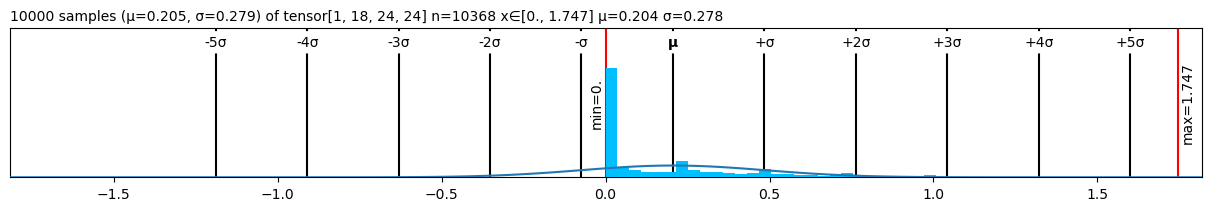

In [56]:
coarse_masks[1].plt

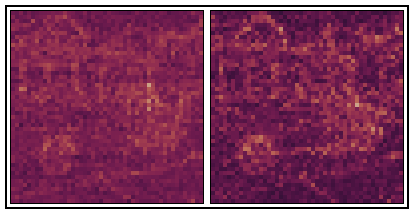

In [57]:
coarse_masks[2].chans(scale=4)

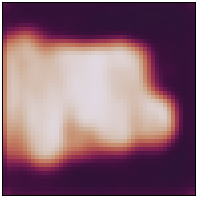

In [58]:
pre_mix.chans(scale=4)

In [59]:
fg_raw, bg_raw = get_raw_attn(results)

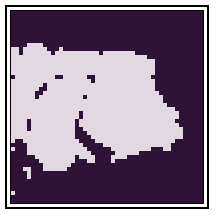

In [64]:
F.sigmoid(fg_raw[0]).chans(scale=4)

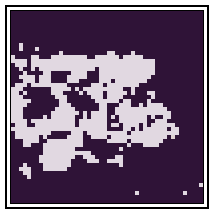

In [65]:
F.sigmoid(bg_raw[0]).chans(scale=4)

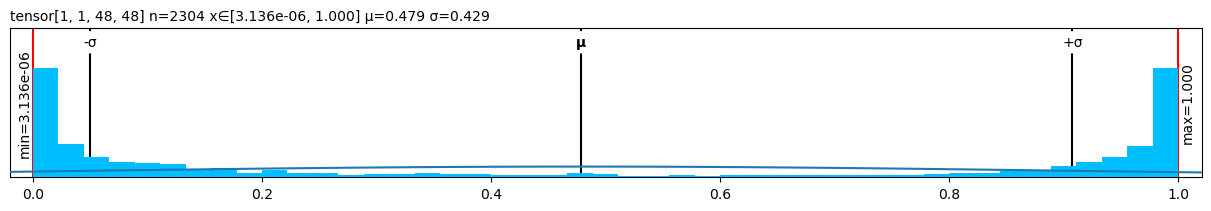

In [ ]:
raw_res.plt(center="range")

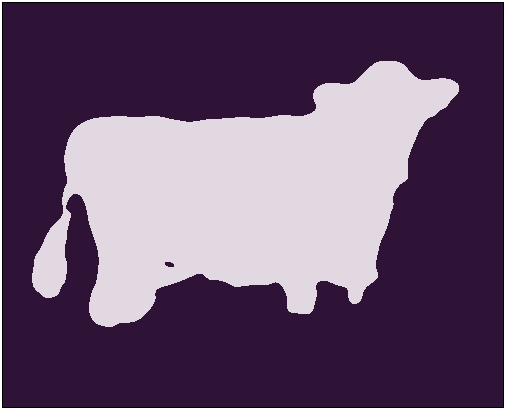

In [110]:
seg = results['logits'].argmax(1)
seg = seg / seg.max()
seg.chans

In [67]:
x = torch.tensor([0.0, 0.50, 0.51, 0.52], dtype=torch.float32)

In [72]:
F.softmax((x) / 2, dim=0)

tensor[4] x∈[0.205, 0.266] μ=0.250 σ=0.030 [0.205, 0.264, 0.265, 0.266]

In [25]:
random_flip

tensor[10] i64 x∈[-1, 0] μ=-0.600 σ=0.516 [-1, 0, -1, -1, 0, -1, -1, 0, -1, 0]

In [94]:
x = torch.rand(10)
mask = torch.rand(10) > 0.5
random_flip = (torch.rand(10) > 0.5) * 2 - 1
multiplier = 10
x = x * random_flip * multiplier
x, mask

(tensor[10] x∈[-2.587, 8.164] μ=2.192 σ=3.730 [1.757, -0.230, 5.991, 3.251, -2.587, 4.568, -1.557, 8.164, -2.163, 4.726],
 tensor[10] bool x∈[False, True] μ=0.400 σ=0.516 [True, True, False, False, False, False, True, True, False, False])

In [98]:
F.softmax(x)[mask].sum(), F.softmax(x)[mask.logical_not()].sum()

(tensor 0.847, tensor 0.153)

In [99]:
F.softmax(torch.stack((x[mask].sum(), x[mask.logical_not()].sum())))

tensor[2] μ=0.500 σ=0.702 [0.003, 0.997]

In [100]:
F.sigmoid(x[mask].sum())

tensor 1.000

In [111]:
coarse_mask1, coarse_mask2, coarse_mask3 = result[ResultDict.COARSE_MASKS]
coarse_mask1 = F.interpolate(coarse_mask1, gt.size()[-2:], mode='bilinear', align_corners=True)
coarse_mask2 = F.interpolate(coarse_mask2, gt.size()[-2:], mode='bilinear', align_corners=True)
coarse_mask3 = F.interpolate(coarse_mask3, gt.size()[-2:], mode='bilinear', align_corners=True)
coarse = torch.cat([coarse_mask1, coarse_mask2, coarse_mask3], dim=1).mean(dim=1).unsqueeze(1)

In [114]:
coarse

tensor[1, 1, 404, 500] n=202000 (0.8Mb) x∈[0.034, 0.659] μ=0.218 σ=0.171

In [117]:
gt

# Label smoothing
gt = F.one_hot(gt, num_classes=2).float()


tensor[1, 404, 500] i64 n=202000 (1.5Mb) x∈[0, 1] μ=0.274 σ=0.446

In [118]:
nn.BCELoss()(coarse, gt.unsqueeze(0).float())

tensor 0.343